In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
from os import path
import itertools
from matplotlib.ticker import ScalarFormatter

In [2]:
%matplotlib inline

In [3]:
!ls data/NYT_new/

bicultural.json		 monocultural.json	other ethnicity.json
biethnic.json		 monoethnic.json	other race.json
biracial.json		 monoracial.json	polyculturalism.json
cultural pluralism.json  multiculturalism.json	polycultural.json
interracial.json	 multicultural.json	polyethnic.json
mixed ethnicity.json	 multiethnic.json	polyracial.json
mixed race.json		 multiracial.json


In [4]:
def load_nyt_json(filename):
    obj = json.load(open(filename))
    words = obj["graph_data"]
    assert len(words) == 1
    only_word = words[0]
    term1 = only_word["term"]
    term2 = path.basename(filename).split(".")[0]
    assert term1 == term2

    df = pd.DataFrame.from_records(only_word["data"])
    df = df.rename(columns={"total_articles_published": "Total", "article_matches": term1})
    database = df[["Total", term1, "year"]]
    return term1, database

In [5]:
def load_nyt_database():
    word, database = load_nyt_json("data/NYT_new/bicultural.json")

    for file in glob.glob("data/NYT_new/*json"):
      word, df = load_nyt_json(file)
      if word == "bicultural": continue
      df.drop("Total", 1, inplace=True)
      df = df.rename(columns={"article_matches": word})
      database = pd.merge(database, df, on="year", how="outer")

    database.set_index("year", inplace=True)
    values = (database.values.T / database.Total.values).T
    values[:, 0] = database.Total.values
    database_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)
    return database_norm

In [6]:
database_norm = load_nyt_database()

In [7]:
class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag

In [8]:
def plot(words):
    markers = itertools.cycle(['s', 'D', '*', 'p', 'h', 'o', '+', 'd'])
    df = pd.rolling_mean(database_norm[words], 10)
    plt.figure(figsize=(16,6))

    for i,word in enumerate(words):
        plt.plot(df.index, df[word], next(markers)+"-",
                 color=str(i/float(len(words))),
                 )
    axis_1 = plt.gca()
    axis_1.set_ylabel("Ratio of New York Times Articles")
    axis_1.set_xlabel("Year")
    axis_1.yaxis.set_major_formatter(FixedOrderFormatter(-6))    
    plt.legend(loc='best')

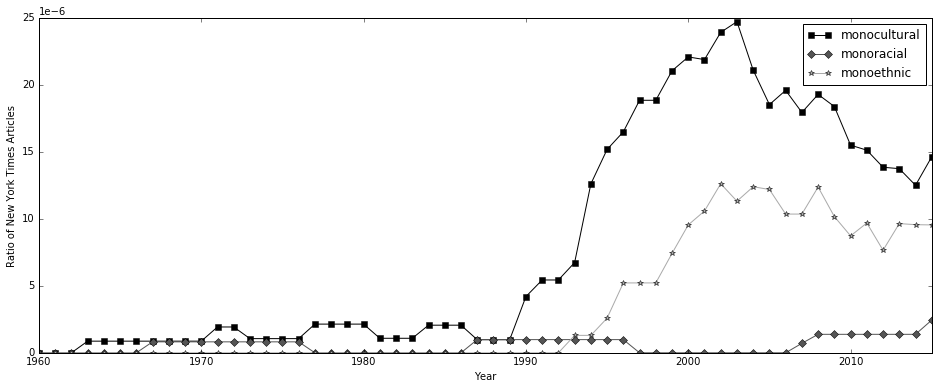

In [9]:
words = ['monocultural', 'monoracial', 'monoethnic']
plot(words)
_ = plt.xlim(1960, 2015)

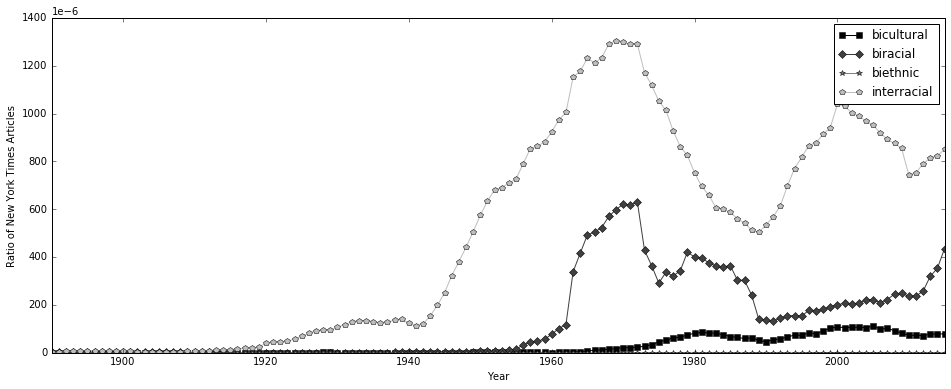

In [10]:
words = ['bicultural', 'biracial', 'biethnic', 'interracial']
plot(words)
_ = plt.xlim(1890, 2015)

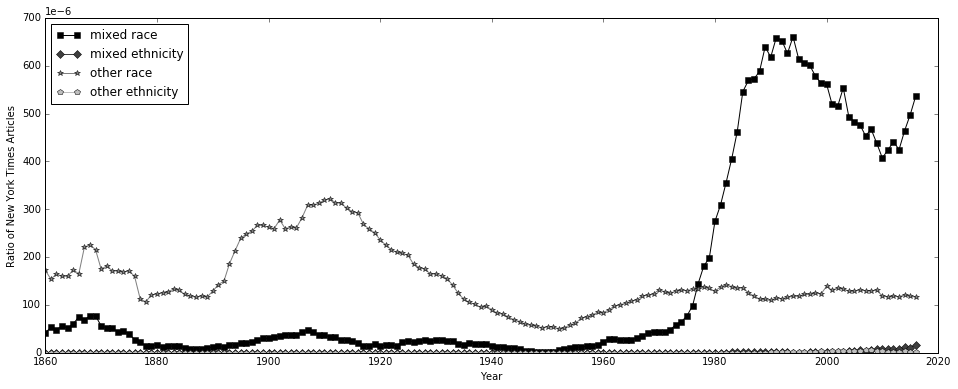

In [11]:
words = ['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity']
plot(words)

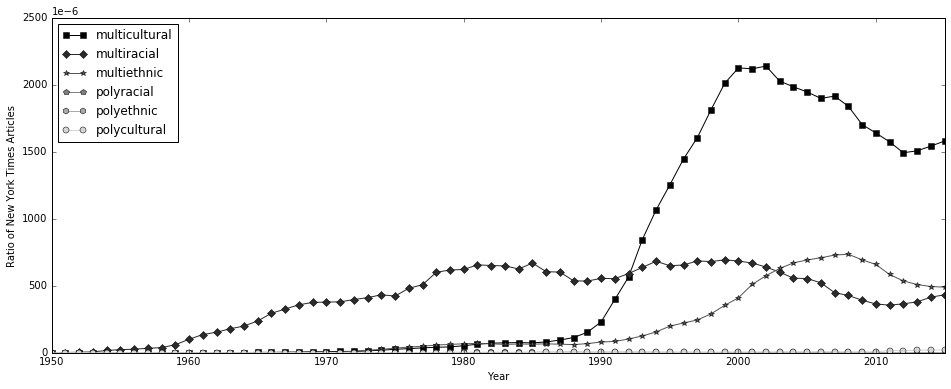

In [12]:
words = ['multicultural', 'multiracial', 'multiethnic', 'polyracial', 'polyethnic', 'polycultural']
plot(words)
_ = plt.xlim(1950, 2015)

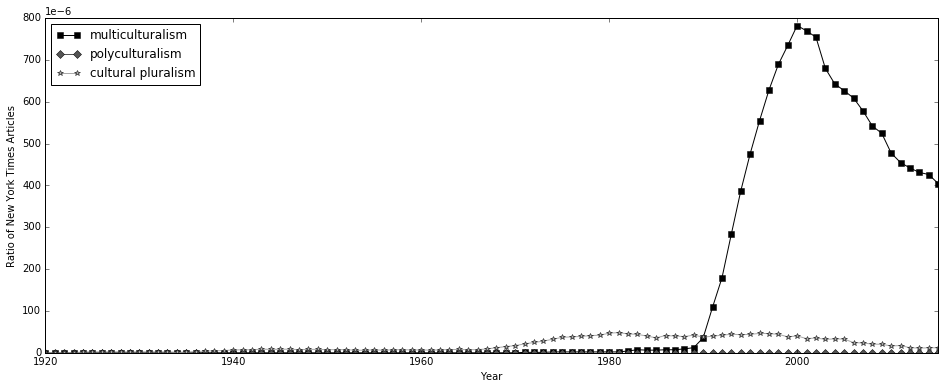

In [13]:
words = ['multiculturalism', 'polyculturalism', 'cultural pluralism']
plot(words)
_ = plt.xlim(1920, 2015)

polyculturalism has no frequency in NYT

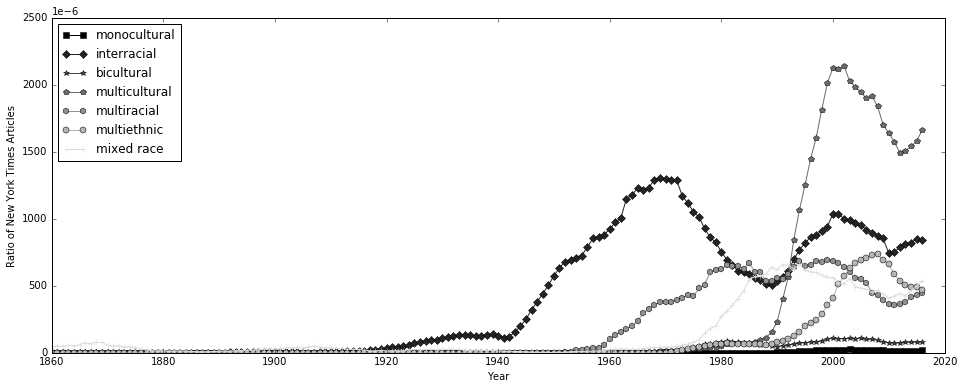

In [14]:
words = ['monocultural', 'interracial', 'bicultural', 'multicultural', 'multiracial', 'multiethnic', 'mixed race']
plot(words)

# To Do

1. Smoothen lines
1. Make in grayscale --> it seems like it may be easier to convert the image to grayscale after the figure is complete--is this right?
1. Use solid, dashed, and dotted lines and markers (I added both of these. I just could not get them to apply to the plots) Why can't we have something like this for our plots: plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^'), but in grayscale?
1. Use the same y-axes ticks for all graphs? We should discuss
1. Add Axis Labels and fix legend (see my attempt)--> could not get it to apply to all the plots. 